In [1]:
MAX_EPOCHS = 2000
PATIENCE = 100
normalize = False

ITEM = "Twisted bow"

INPUT_WIDTH=30
LABEL_WIDTH=30

# LABEL_COLUMNS=['average','avgHighPrice', 'avgLowPrice']
# LABEL_COLUMNS=['average','avgHighPrice', 'avgLowPrice','lowPriceVolume', 'highPriceVolume']
LABEL_COLUMNS=['average']
CONV_WIDTH = 30 # given x stamps, predict 1 in the future


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

import DateTimeHelper
import HistoricalDataHelper

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Get Data

In [3]:
df = DateTimeHelper.getDT(ITEM, "6h")
df

,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,average
timestamp,,,,,
2023-01-07 12:00:00,1.285852e+09,1280708152,34,47,1.282867e+09
2023-01-07 18:00:00,1.285353e+09,1281679156,65,78,1.283349e+09
2023-01-08 00:00:00,1.285309e+09,1282396278,57,93,1.283503e+09
2023-01-08 06:00:00,1.287134e+09,1282488972,30,51,1.284209e+09
2023-01-08 12:00:00,1.287021e+09,1283452861,50,51,1.285219e+09
...,...,...,...,...,...
2023-04-07 12:00:00,1.389758e+09,1387740334,58,65,1.388692e+09
2023-04-07 18:00:00,1.391192e+09,1387542383,56,107,1.388796e+09
2023-04-08 00:00:00,1.390868e+09,1387320814,57,74,1.388864e+09


## Append Historical Data

In [4]:
# import the Historical data
test = HistoricalDataHelper.get_historical(ITEM)
print(test.empty)

False


In [5]:
if not test.empty:
    test = test.transpose()
    test = test[['avgHighPrice', 'avgLowPrice', 'highPriceVolume', 'lowPriceVolume']]
    test= DateTimeHelper.addAverage(test)
    test.index.name = "timestamp"
    # now we append the historical data to the curr data
    # df = df.append(test)
    df = pd.concat([df,test])
    df

# Prepare Data

In [6]:
df2 = df.copy()

layer = tf.keras.layers.Normalization(invert=True)
layer.adapt(df)

df = DateTimeHelper.addAverage(df)

if(normalize):
    df = tf.keras.utils.normalize(df)

print(np.any(np.isnan(df)))
df

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-08 15:11:20.027217: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


False


,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,average
timestamp,,,,,
2023-01-07 12:00:00,1.285852e+09,1280708152,34,47,1.282867e+09
2023-01-07 18:00:00,1.285353e+09,1281679156,65,78,1.283349e+09
2023-01-08 00:00:00,1.285309e+09,1282396278,57,93,1.283503e+09
2023-01-08 06:00:00,1.287134e+09,1282488972,30,51,1.284209e+09
2023-01-08 12:00:00,1.287021e+09,1283452861,50,51,1.285219e+09
...,...,...,...,...,...
2021-04-12 12:00:00,1.068588e+09,1068134805,119,122,1.068359e+09
2021-04-11 12:00:00,1.069503e+09,1069155670,112,139,1.069311e+09
2021-04-10 12:00:00,1.066879e+09,1066398349,164,152,1.066648e+09


In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

df = df.reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df = df.sort_index()

n = len(df)
print(n)
print(len(df2))
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
og_test_df = df2[int(n*0.9):]

num_features = df.shape[1]

994
994


# Window Generator Class

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    # self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [9]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [10]:
def plot(self, model=None, plot_col='average', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [11]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [12]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# ML

## Define Fit

In [13]:
def compile_and_fit(model:tf.keras.models.Sequential, window, patience=PATIENCE):
# Include the epoch in the file name (uses `str.format`)
  checkpoint_path = "Models/cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)
  
  batch_size = 32
  
  # Create a callback that saves the model's weights every 5 epochs
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path, 
      verbose=1, 
      save_weights_only=True,
      save_freq=100*batch_size)
  
  early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    start_from_epoch=MAX_EPOCHS/5,
                                                    mode='min')
  early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                    patience=patience,
                                                    start_from_epoch=MAX_EPOCHS/5,
                                                    mode='min')
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping1, early_stopping2, cp_callback])
  return history

## Setup ML/Windows

In [14]:
window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,
    label_columns=LABEL_COLUMNS)
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['average']

In [15]:
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['average'])
conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['average']

In [16]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['average'])

wide_conv_window

Total window size: 54
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
Label column name(s): ['average']

# Linear

In [17]:
# linear
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

### Train Linear

In [18]:
history = compile_and_fit(linear, window)
# history = linear.load_weights('Model/linear_cp.ckpt')

Epoch 1/2000
21/21 [==============================] - 1s 21ms/step - loss: 274528262246367232.0000 - mean_absolute_error: 516943552.0000 - val_loss: 373235338081992704.0000 - val_mean_absolute_error: 610866560.0000
Epoch 2/2000
21/21 [==============================] - 0s 9ms/step - loss: 209813189678858240.0000 - mean_absolute_error: 451861984.0000 - val_loss: 281538164269514752.0000 - val_mean_absolute_error: 530545792.0000
Epoch 3/2000
21/21 [==============================] - 0s 9ms/step - loss: 156732496321445888.0000 - mean_absolute_error: 390470688.0000 - val_loss: 207480627300139008.0000 - val_mean_absolute_error: 455451360.0000
Epoch 4/2000
21/21 [==============================] - 0s 11ms/step - loss: 114489311121899520.0000 - mean_absolute_error: 333628512.0000 - val_loss: 149703507463634944.0000 - val_mean_absolute_error: 386872320.0000
Epoch 5/2000
21/21 [==============================] - 0s 9ms/step - loss: 81783332731355136.0000 - mean_absolute_error: 281880736.0000 - val_l

### Linear Results

In [19]:
# wide_window.plot(linear)
y_pred = linear.predict(test_df)
for i in range(len(y_pred)):

    if normalize:
        print("" + str(np.array(layer(y_pred[i]))[0][4]) + " vs " + str(np.array(layer(test_df['average'][i]))[0][4]) + " vs " + str(og_test_df['average'][i]))
    else:
        print("" + str(y_pred[i][0]) + " vs " + str(test_df['average'][i]))

4/4 [==============================] - 0s 3ms/step
1387012400.0 vs 1386869461.9
1388678300.0 vs 1387871849.9557521
1393142000.0 vs 1392414281.0
1393150600.0 vs 1392156482.857143
1389478300.0 vs 1390358954.969072
1395745400.0 vs 1394674135.3968253
1397331200.0 vs 1396722489.857143
1402605800.0 vs 1401790357.531915
1405597600.0 vs 1404687160.7115386
1405112700.0 vs 1404036455.0869565
1404260000.0 vs 1403549110.115942
1406433500.0 vs 1405681154.534091
1411261200.0 vs 1410255041.142857
1408101400.0 vs 1407349893.1045752
1406042800.0 vs 1405613827.6774194
1406837000.0 vs 1406194960.3894737
1406194000.0 vs 1405512948.3605442
1404184800.0 vs 1403402716.664122
1403000600.0 vs 1401829874.6056337
1399148800.0 vs 1398379258.8837209
1388942300.0 vs 1387500482.3372092
1389706600.0 vs 1388281523.0514705
1393666200.0 vs 1392015085.5333333
1392329700.0 vs 1391212317.89899
1387233000.0 vs 1386088567.0828402
1384884200.0 vs 1383940605.3076923
1385177500.0 vs 1384152008.8088236
1385381600.0 vs 1384017688

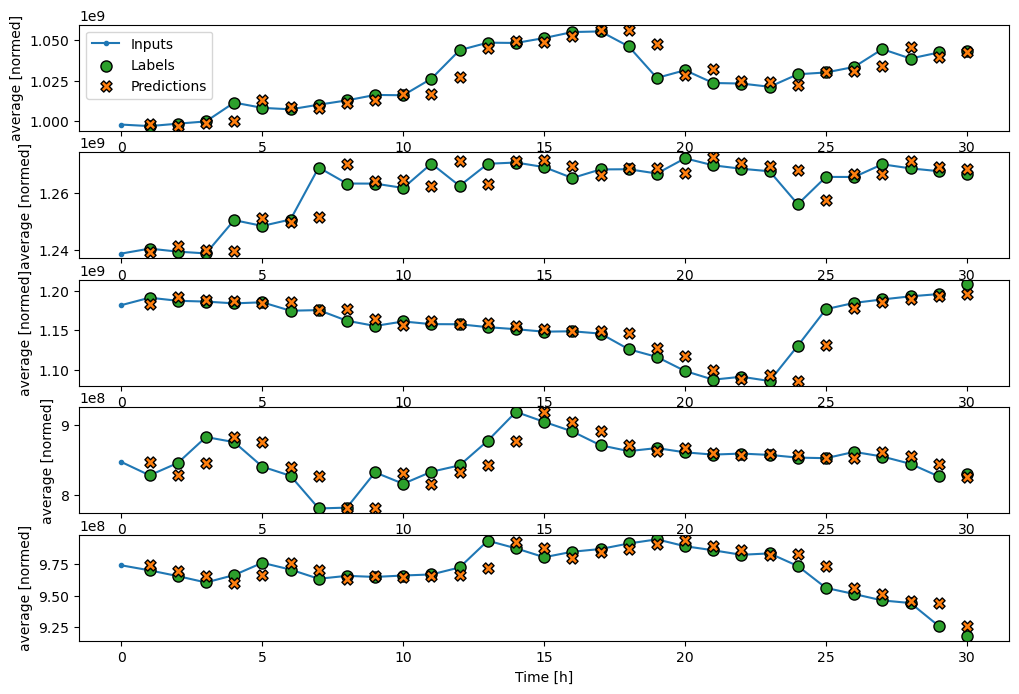

In [20]:
window.plot(linear)

<Axes: xlabel='timestamp'>

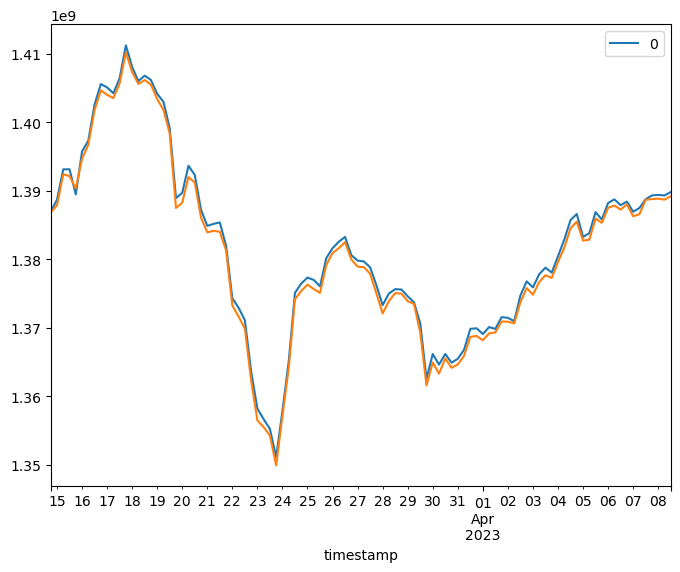

In [21]:
p = pd.DataFrame(y_pred)
p = p.reset_index()
for i in range(len(p)):
    p.loc[i,'index'] = test_df.index[i]
p= p.set_index('index')

p.plot()
test_df['average'].plot()

In [22]:
linear.save('Models/Linear')

INFO:tensorflow:Assets written to: Model/Linear/assets


# Conv Model

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

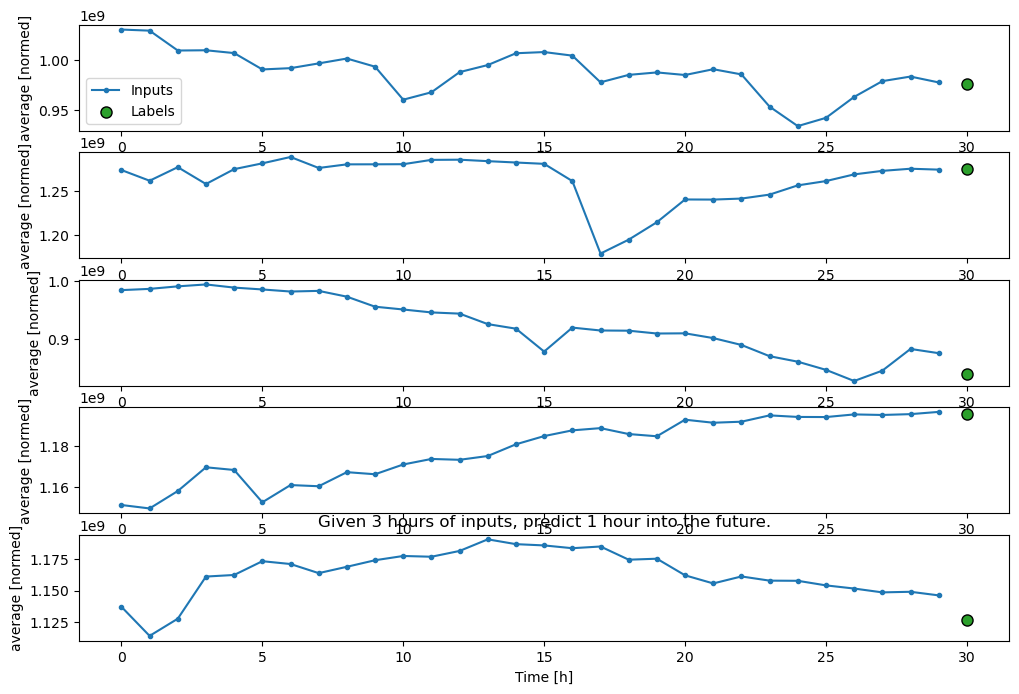

In [23]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [24]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [25]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/2000
21/21 [==============================] - 1s 25ms/step - loss: 237064224596033536.0000 - mean_absolute_error: 326244864.0000 - val_loss: 48465059508125696.0000 - val_mean_absolute_error: 219925696.0000
Epoch 2/2000
21/21 [==============================] - 0s 9ms/step - loss: 9186354151817216.0000 - mean_absolute_error: 79362064.0000 - val_loss: 2593852619751424.0000 - val_mean_absolute_error: 50065488.0000
Epoch 3/2000
21/21 [==============================] - 0s 9ms/step - loss: 2469186899017728.0000 - mean_absolute_error: 39530284.0000 - val_loss: 569228457410560.0000 - val_mean_absolute_error: 21996952.0000
Epoch 4/2000
21/21 [==============================] - 0s 9ms/step - loss: 1859188665876480.0000 - mean_absolute_error: 32125020.0000 - val_loss: 118484130332672.0000 - val_mean_absolute_error: 8661793.0000
Epoch 5/2000
21/21 [==============================] - 0s 9ms/step - loss: 1678463018729472.0000 - mean_absolute_error: 30332620.0000 - val_loss: 131170398371840.0000

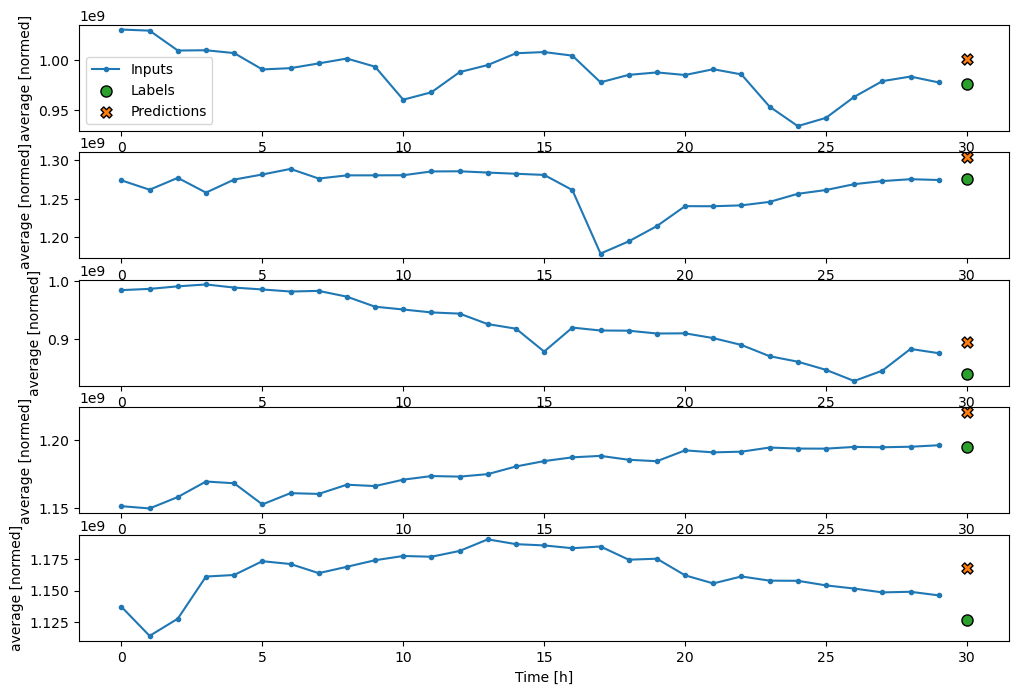

In [26]:
conv_window.plot(multi_step_dense)

In [27]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 5)
Output shape: (32, 1, 1)


In [28]:
history = compile_and_fit(conv_model, conv_window)

Epoch 1/2000
21/21 [==============================] - 1s 20ms/step - loss: 450355427251585024.0000 - mean_absolute_error: 535277312.0000 - val_loss: 115269302952656896.0000 - val_mean_absolute_error: 339403904.0000
Epoch 2/2000
21/21 [==============================] - 0s 12ms/step - loss: 28174227400032256.0000 - mean_absolute_error: 139434192.0000 - val_loss: 15108714621042688.0000 - val_mean_absolute_error: 122659592.0000
Epoch 3/2000
21/21 [==============================] - 0s 12ms/step - loss: 3559569305370624.0000 - mean_absolute_error: 48629012.0000 - val_loss: 297947451359232.0000 - val_mean_absolute_error: 15589002.0000
Epoch 4/2000
21/21 [==============================] - 0s 13ms/step - loss: 1363063437524992.0000 - mean_absolute_error: 28044794.0000 - val_loss: 325694852694016.0000 - val_mean_absolute_error: 16433749.0000
Epoch 5/2000
21/21 [==============================] - 0s 12ms/step - loss: 1260823351656448.0000 - mean_absolute_error: 26191746.0000 - val_loss: 6213436912

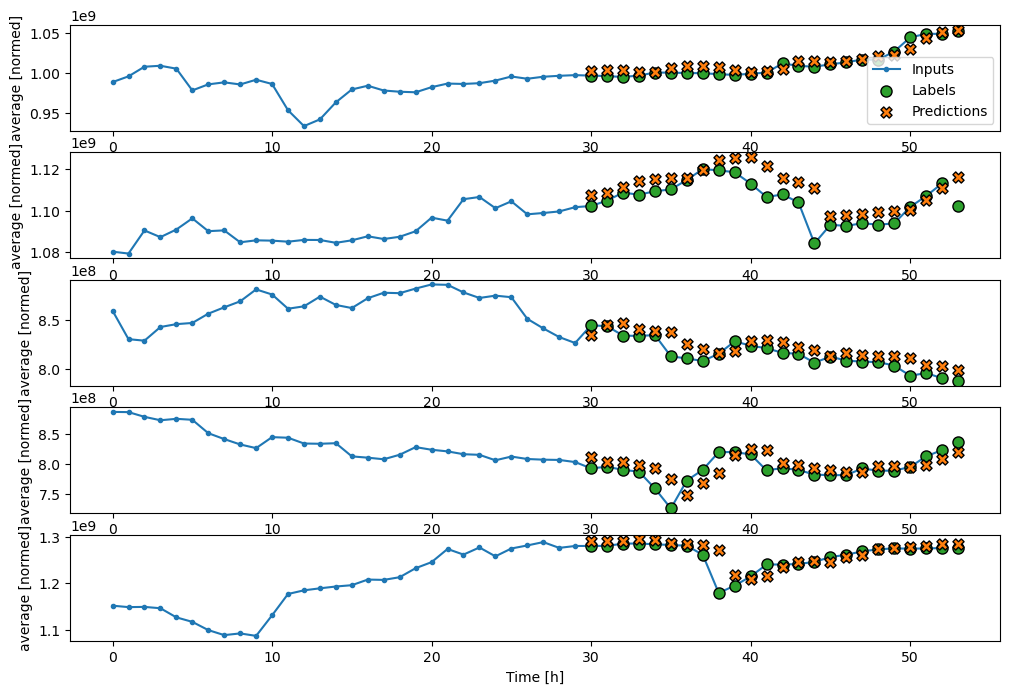

In [29]:
wide_conv_window.plot(conv_model)

In [30]:
conv_model.save('Models/Conv_Model')

INFO:tensorflow:Assets written to: Models/Conv_Model/assets


INFO:tensorflow:Assets written to: Models/Conv_Model/assets


In [31]:
"""
# wide_window.plot(linear)
# test_df = tf.expand_dims(test_df, axis=-1)
y_pred = conv_model.predict(test_df)
for i in range(len(y_pred)):

    if normalize:
        print("" + str(np.array(layer(y_pred[i]))[0][4]) + " vs " + str(np.array(layer(test_df['average'][i]))[0][4]) + " vs " + str(og_test_df['average'][i]))
    else:
        print("" + str(y_pred[i][0]) + " vs " + str(test_df['average'][i]))

p = pd.DataFrame(y_pred)
p = p.reset_index()
for i in range(len(p)):
    p.loc[i,'index'] = test_df.index[i]
p= p.set_index('index')

p.plot()
test_df['average'].plot()
"""

'\n# wide_window.plot(linear)\n# test_df = tf.expand_dims(test_df, axis=-1)\ny_pred = conv_model.predict(test_df)\nfor i in range(len(y_pred)):\n\n    if normalize:\n        print("" + str(np.array(layer(y_pred[i]))[0][4]) + " vs " + str(np.array(layer(test_df[\'average\'][i]))[0][4]) + " vs " + str(og_test_df[\'average\'][i]))\n    else:\n        print("" + str(y_pred[i][0]) + " vs " + str(test_df[\'average\'][i]))\n\np = pd.DataFrame(y_pred)\np = p.reset_index()\nfor i in range(len(p)):\n    p.loc[i,\'index\'] = test_df.index[i]\np= p.set_index(\'index\')\n\np.plot()\ntest_df[\'average\'].plot()\n'

In [32]:
new_model = tf.keras.models.load_model('Models/Linear')

OSError: No file or directory found at Models/Linear